In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import infercnvpy as cnv
import mygene

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from matplotlib import colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from statannot import add_stat_annotation

In [56]:
adata = sc.read_h5ad('scRNAseq_pancan_MALE_after_SCVI.h5ad')
adata

AnnData object with n_obs × n_vars = 497055 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'Celltype2_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

# Get gene location

In [59]:
def get_gene_info_from_mygene(gene_list):
    mg = mygene.MyGeneInfo()
    return mg.querymany(gene_list, scopes='symbol', fields='chromosome,genomic_pos', species='human', returnall=True)

gene_info = get_gene_info_from_mygene(adata.var_names.tolist())
# Create a dataframe with the fetched data
gene_df = pd.DataFrame({
    'gene': [entry.get('query', None) for entry in gene_info['out']],
    'chromosome': [entry.get('genomic_pos', {}).get('chr', None) if isinstance(entry.get('genomic_pos', {}), dict) else None for entry in gene_info['out']],
    'start': [entry.get('genomic_pos', {}).get('start', None) if isinstance(entry.get('genomic_pos', {}), dict) else None for entry in gene_info['out']],
    'end': [entry.get('genomic_pos', {}).get('end', None) if isinstance(entry.get('genomic_pos', {}), dict) else None for entry in gene_info['out']]
})
gene_df = gene_df.loc[~gene_df['chromosome'].isnull(),:].copy()
gene_df = gene_df.drop_duplicates(subset='gene')
gene_df.index = gene_df['gene'].copy()
gene_df

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

,gene,chromosome,start,end
gene,,,,
LINC00115,LINC00115,1,824228.0,827539.0
FAM41C,FAM41C,1,868071.0,876903.0
SAMD11,SAMD11,1,923923.0,944575.0
NOC2L,NOC2L,1,944203.0,959309.0
KLHL17,KLHL17,1,960584.0,965719.0
...,...,...,...,...
C21orf58,C21orf58,21,46300181.0,46323875.0
PCNT,PCNT,21,46324124.0,46445769.0
DIP2A,DIP2A,21,46458891.0,46570015.0


In [60]:
gene_df.to_csv('scRNAseq_gene_chr_info.csv')

In [61]:
adata=adata[:,gene_df["gene"].to_list()].copy()
adata.obs['Celltype1_LOY'] = adata.obs["Celltype1"].astype(str)+ "_" +adata.obs["LOY"].astype(str)
adata

AnnData object with n_obs × n_vars = 497055 × 12827
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY', 'Celltype1_LOY'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'Celltype2_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [62]:
adata.var['chromosome']="chr"+gene_df['chromosome'].copy()
adata.var['start']=gene_df['start'].copy()
adata.var['end']=gene_df['end'].copy()

# Infer CNV

In [65]:
# Provide WTY non-epithelial cell types as "normal cells".
cnv.tl.infercnv(
    adata,
    reference_key="Celltype1_LOY",
    reference_cat=[
        "T_NK_cell_WTY_SCR",
        "Myeloid_cell_WTY_SCR",
        "Endothelium_WTY_SCR",
        "Fibroblast_WTY_SCR",
        "B_Plasma_cell_WTY_SCR",
    ],
    window_size=100,
    step=1
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [66]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)
cnv.tl.umap(adata)

###Score
cnv.tl.cnv_score(adata)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [7]:
Epi = adata[adata.obs['Celltype1']=='Epithelium',:].copy()
Epi

AnnData object with n_obs × n_vars = 157029 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY', 'Celltype1_LOY', 'cnv_leiden', 'cnv_score'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'Celltype2_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

# Result visualization

In [4]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('fontTools.subset').setLevel(logging.ERROR)

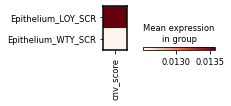

In [89]:
#ExtendedData_Fig5c
sc.pl.matrixplot(Epi, 
              var_names=["cnv_score"], 
              groupby='Celltype1_LOY', 
              dendrogram=False, 
              cmap='Reds',
              figsize=(2,0.8),
              save = 'ExtendedData_Fig5c_scRNAseq_pancan_MALE_Epithelium_CNVscore_dot.pdf' )

In [19]:
#Wilcox test for cnv score
import scipy
res = scipy.stats.ranksums(Epi.obs.loc[Epi.obs['LOY']=='LOY_SCR','cnv_score'].dropna(),
                           Epi.obs.loc[Epi.obs['LOY']=='WTY_SCR','cnv_score'].dropna())
pd.DataFrame(res).T

,0,1
0,56.385547,0.0


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
No arti

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

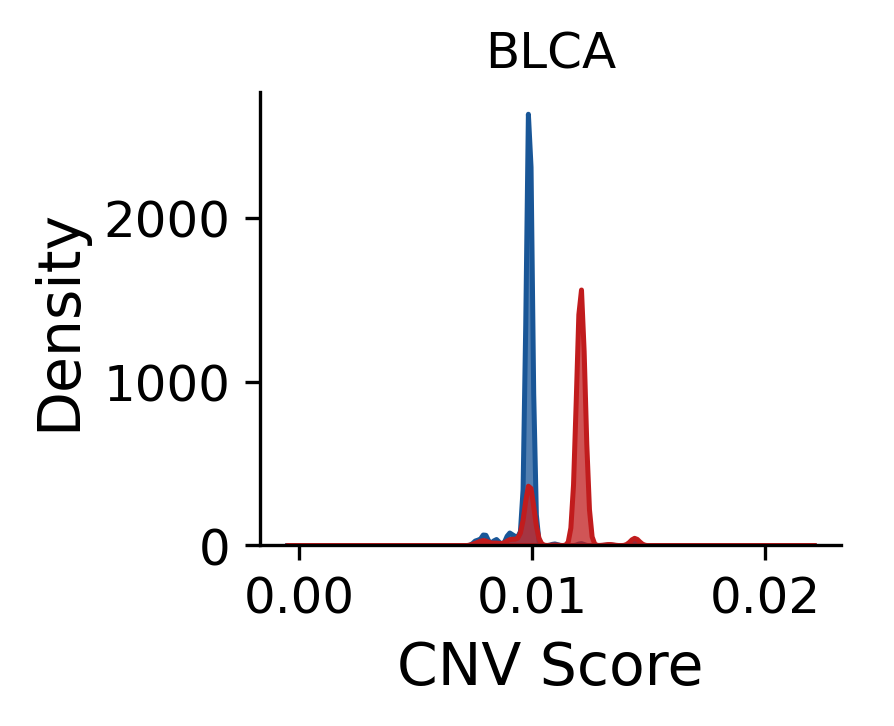

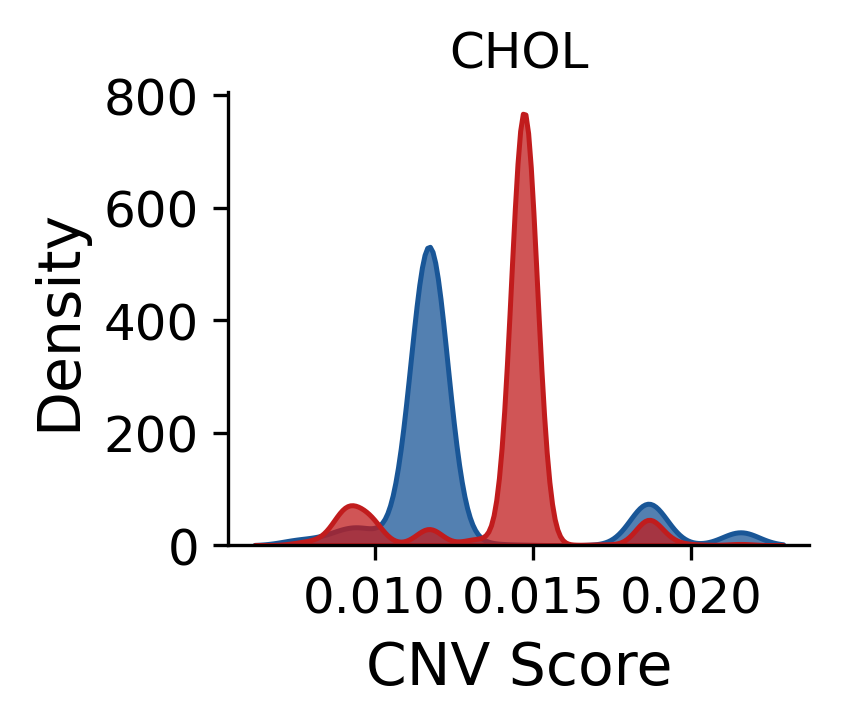

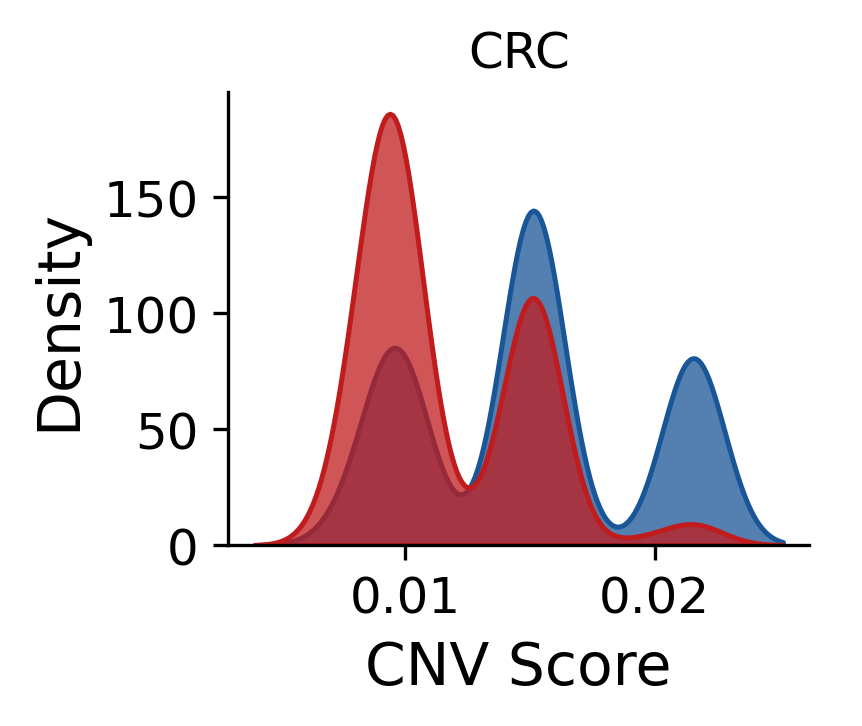

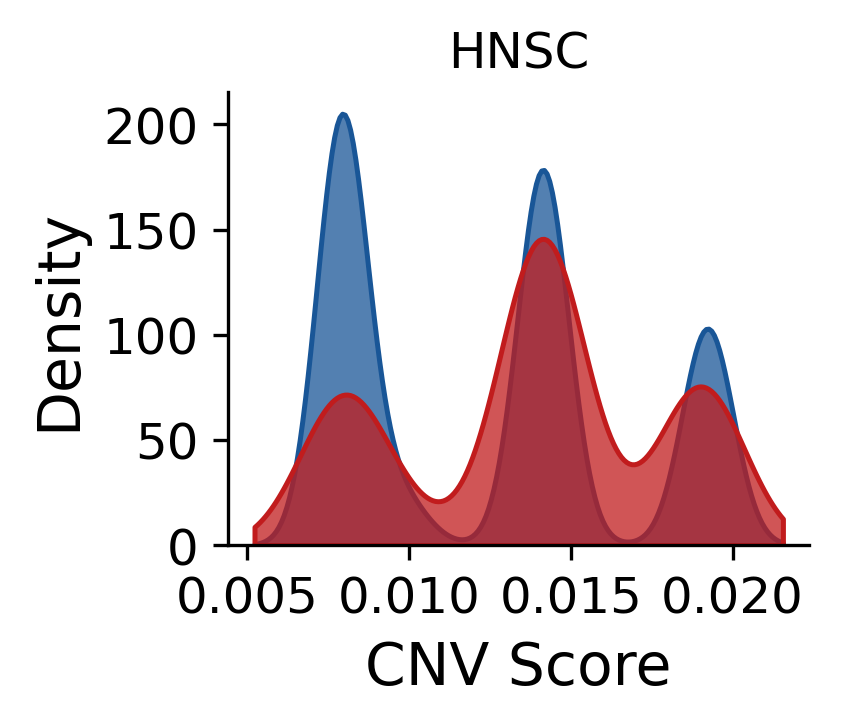

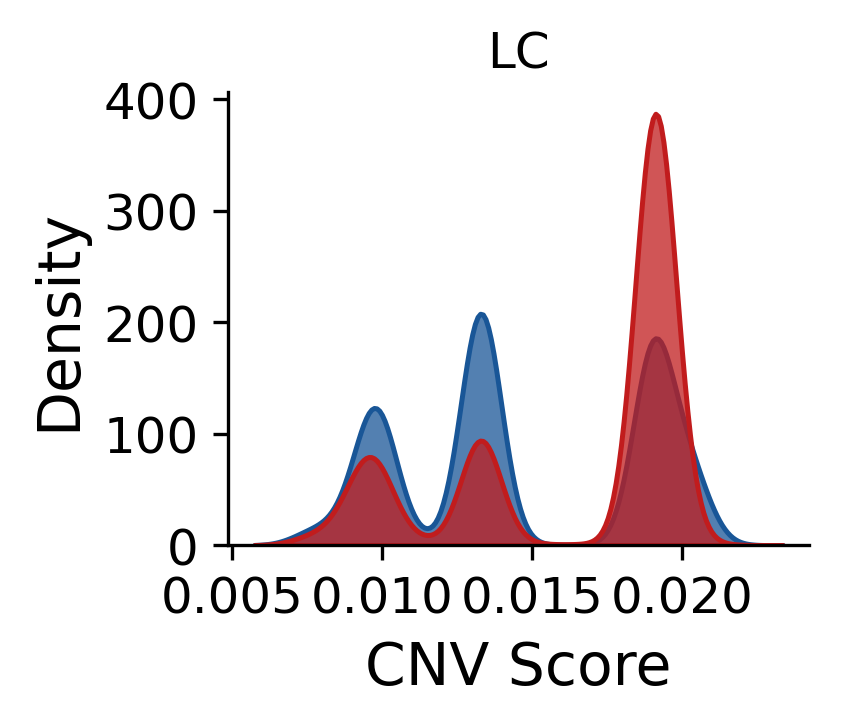

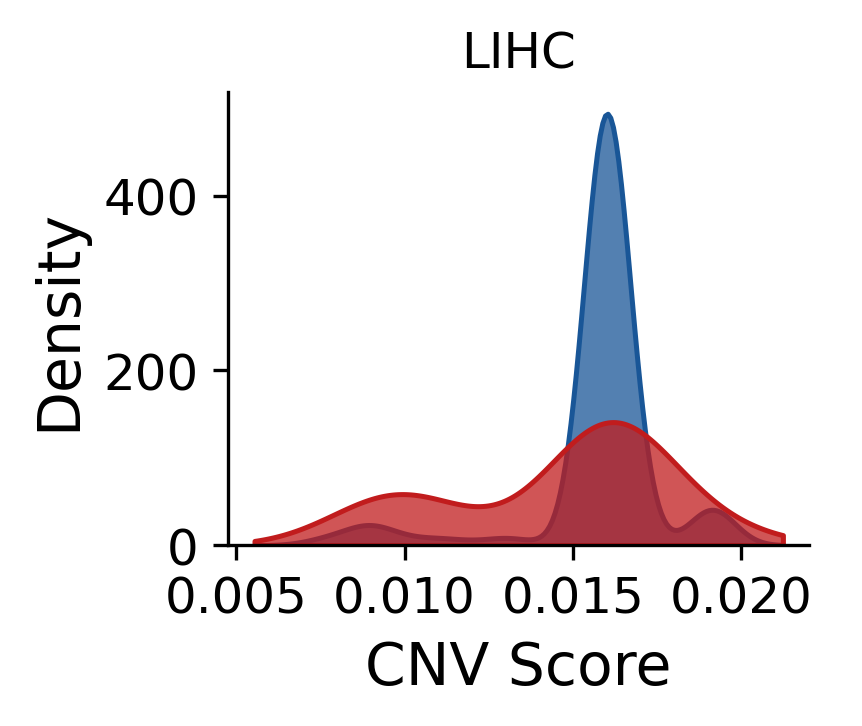

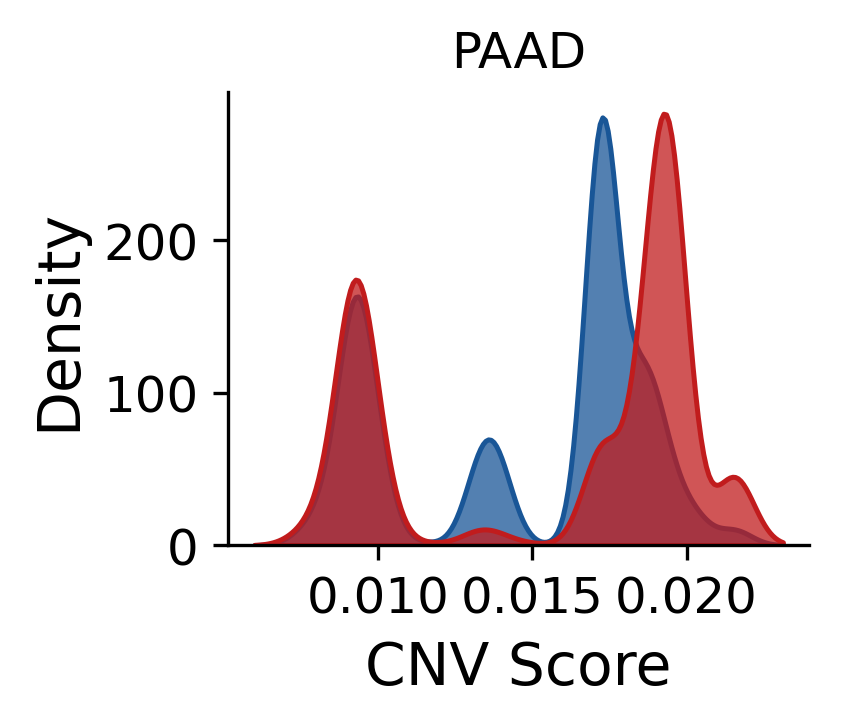

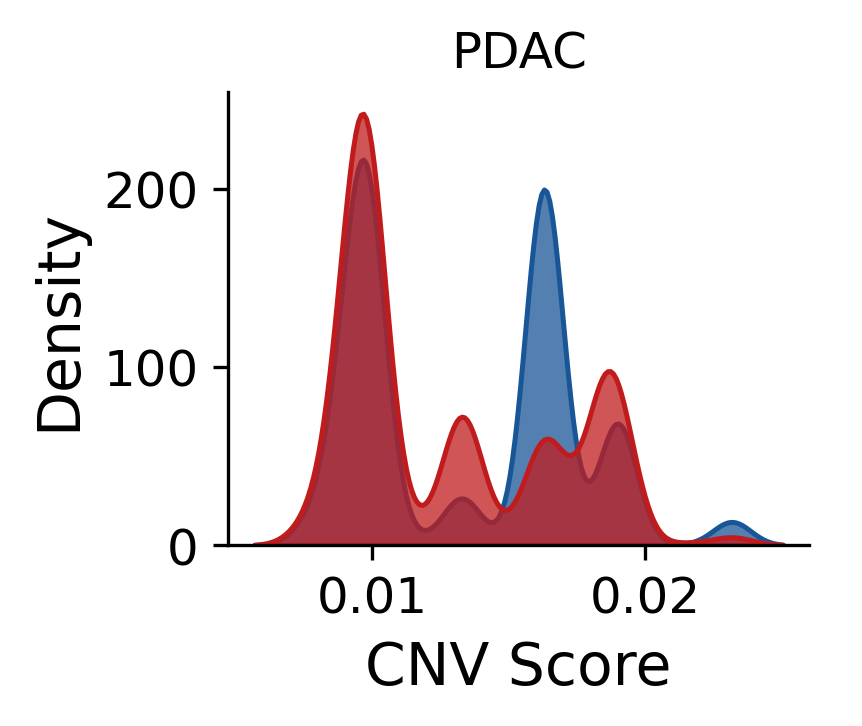

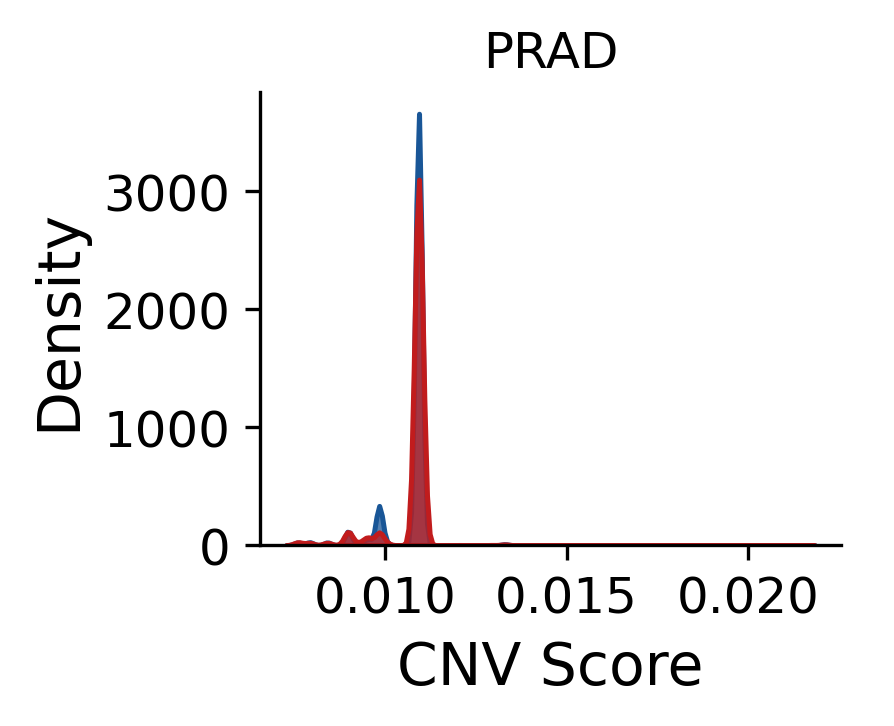

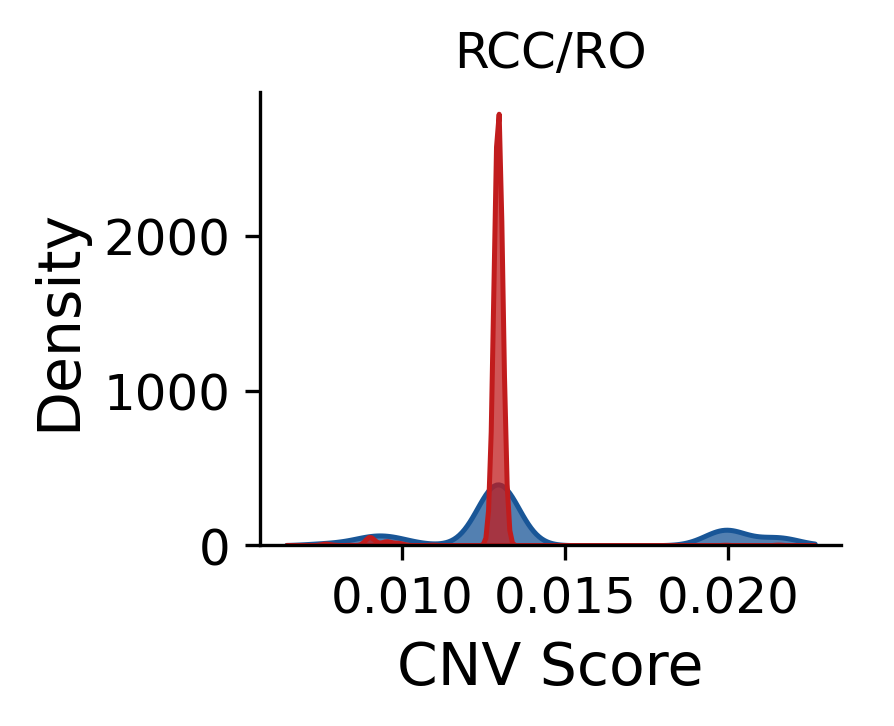

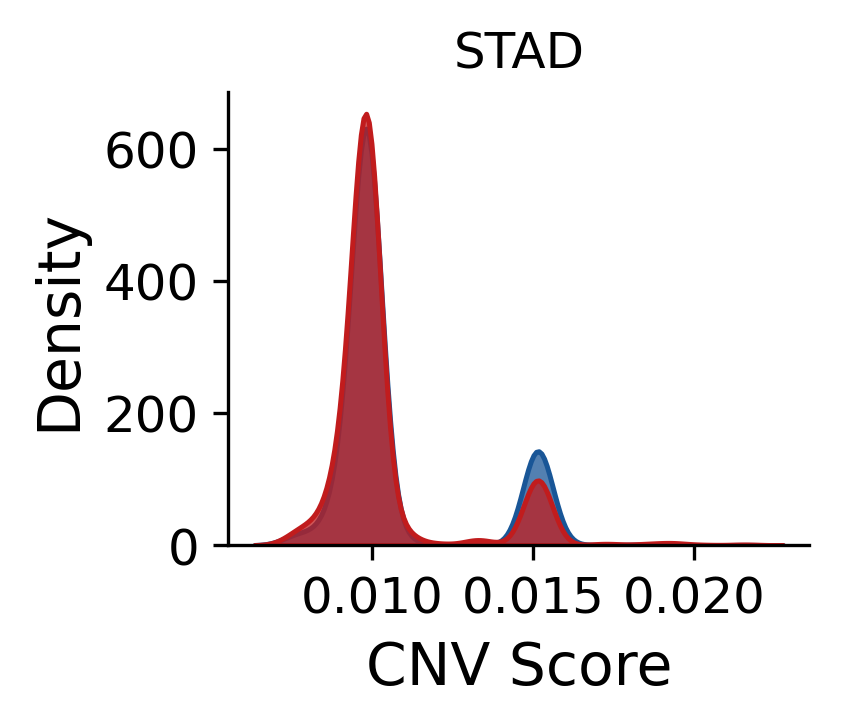

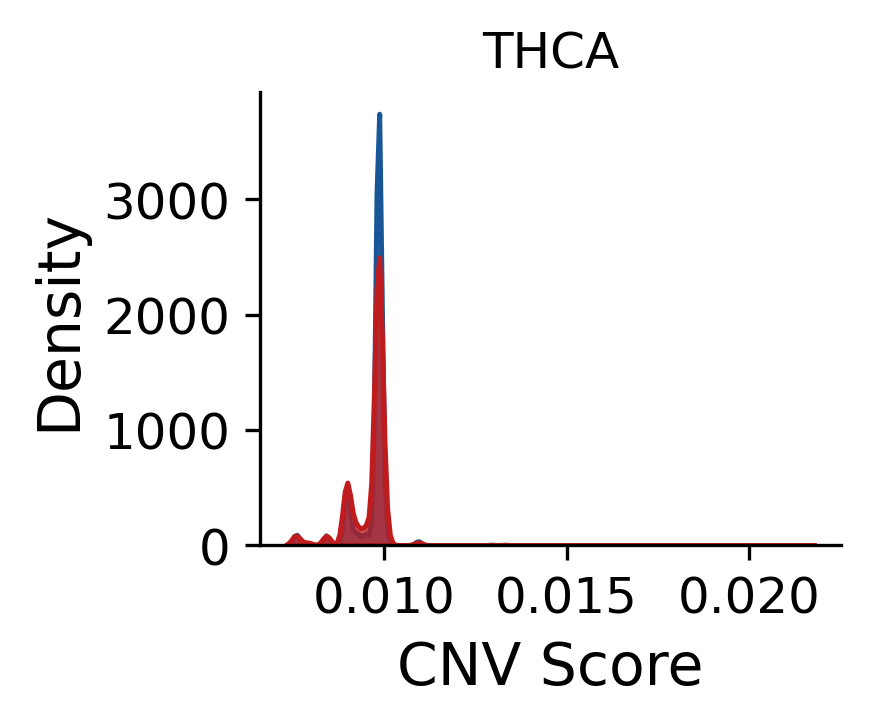

In [13]:
#ExtendedData Fig5b
data = Epi.obs.copy()
for can in data['Cancertype_TCGA'].cat.categories:
    palette = {'LOY_SCR':'#c11c1d', 'WTY_SCR':'#195697'}
    sub_data = data.loc[data['Cancertype_TCGA']==can,:].copy()

    fig, ax = plt.subplots(figsize=(2.5,2), dpi= 300)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.kdeplot(data=sub_data, x='cnv_score', hue='LOY',
                fill=True, common_norm=False, common_grid=True,
                alpha=0.75,linewidth=1.2, palette=palette)


    plt.title(can, fontsize=12)
    plt.xlabel('CNV Score', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(loc = (1,0.5), fontsize = 7, frameon=False)
    
    ax.grid(False)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    can = can.replace('/','_')
    plt.savefig(f'CNV_percancer/ExtendedData_Fig5d_scRNAseq_pancan_Epi_CNVscoredensity_plot_{can}.pdf', bbox_inches='tight', dpi=300)